In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "SF Pro Display"

In [2]:
DATA_DIR = os.path.join(os.getcwd(), "data")

TRAIN_PERIOD = pd.date_range("2011-01-05", "2018-12-31", freq="10D")
TEST_PERIOD = pd.date_range("2019-06-27", "2019-12-31", freq="10D")
BASELINE_DATE = pd.to_datetime("2002-05-21")

CONFIG = [
    [True, 1, 5],
    [True, 5, 5],
    [True, 10, 5],
    [False, 10, 5]
]


In [3]:
from StockHelper import Stock, StockPile, FACTORS

stocks = ["AAPL", "AXP", "AMGN", "BA", "CAT", "CVX", "CSCO", "GS"]
djia = pd.read_csv(os.path.join(DATA_DIR, "DJIA.csv"), parse_dates=["Date"])
dow30 = StockPile("DOW30", djia)
for stock in stocks:
    df_price = pd.read_csv(os.path.join(DATA_DIR, f"{stock}.csv"), parse_dates=["Date"])
    df_stats = pd.read_csv(
        os.path.join(DATA_DIR, f"{stock}_STAT.csv"), parse_dates=["Date"]
    )
    dow30.addStock(Stock(stock, df_price, df_stats))


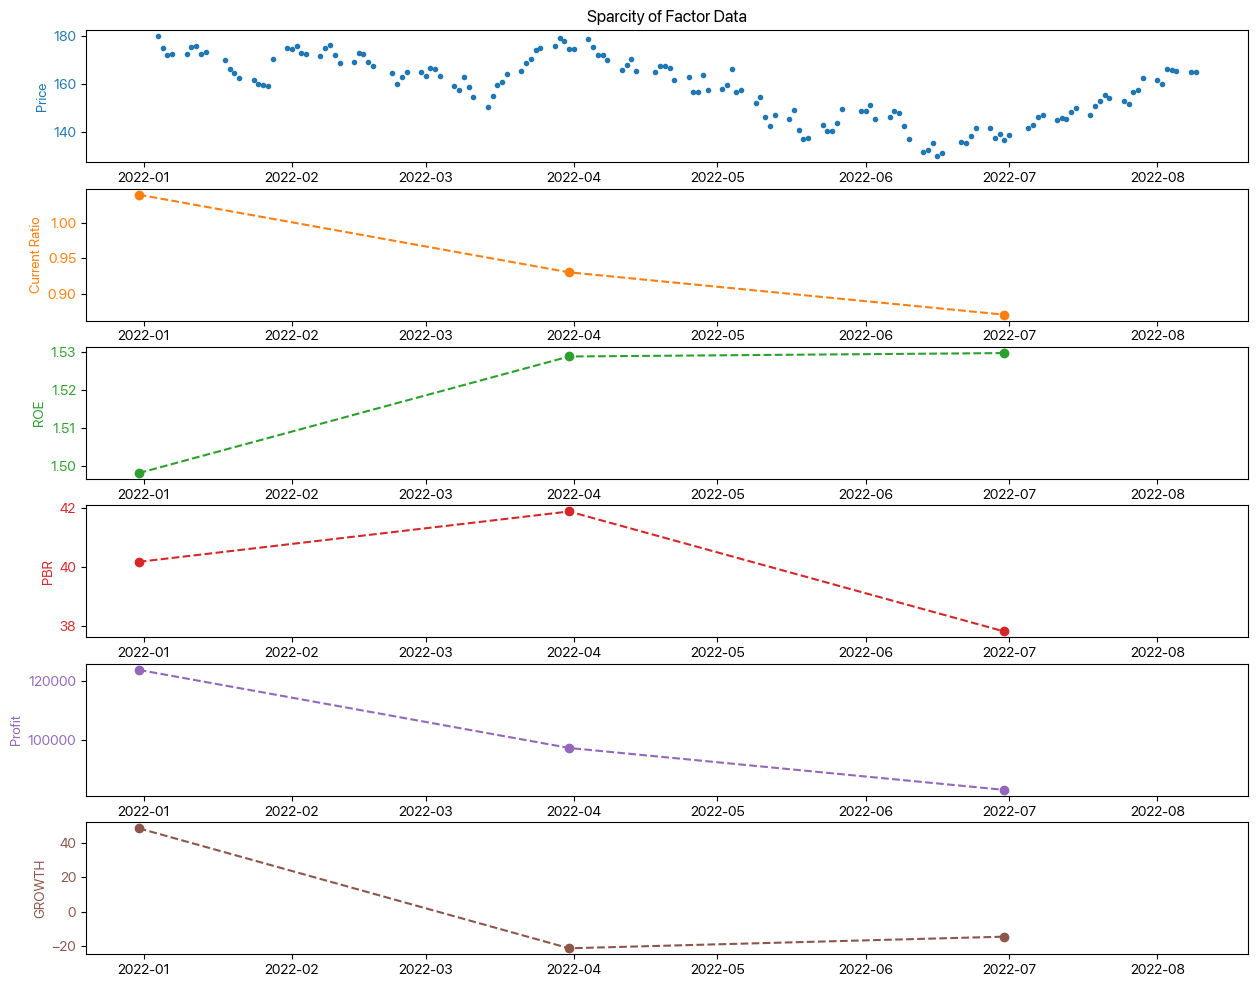

In [4]:
# Plot Price and stats in multiple axis
preview = 3

fig = plt.figure(figsize=(15, 12))
ax = plt.subplot(6, 1, 1)
ax.scatter(
    dow30.stocks[0].df["Date"].tail(150),
    dow30.stocks[0].df["Close"].tail(150),
    marker='.',
    label="Price",
    color="tab:blue",
)
ax.set_ylabel("Price", color="tab:blue")
ax.tick_params(axis="y", labelcolor="tab:blue")
ax.set_title("Sparcity of Factor Data")
colors = ["tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
colors.reverse()
for factor in dow30.stocks[0].dfStatRaw.columns[1:]:
    color = colors.pop()
    plt.subplot(6, 1, (6 - len(colors)), sharex=ax)
    plt.plot(
        dow30.stocks[0].dfStatRaw["Date"].tail(preview),
        dow30.stocks[0].dfStatRaw[factor].tail(preview),
        "o--",
        label=factor,
        color=color,
    )
    plt.ylabel(factor, color=color)
    plt.tick_params(axis="y", labelcolor=color)


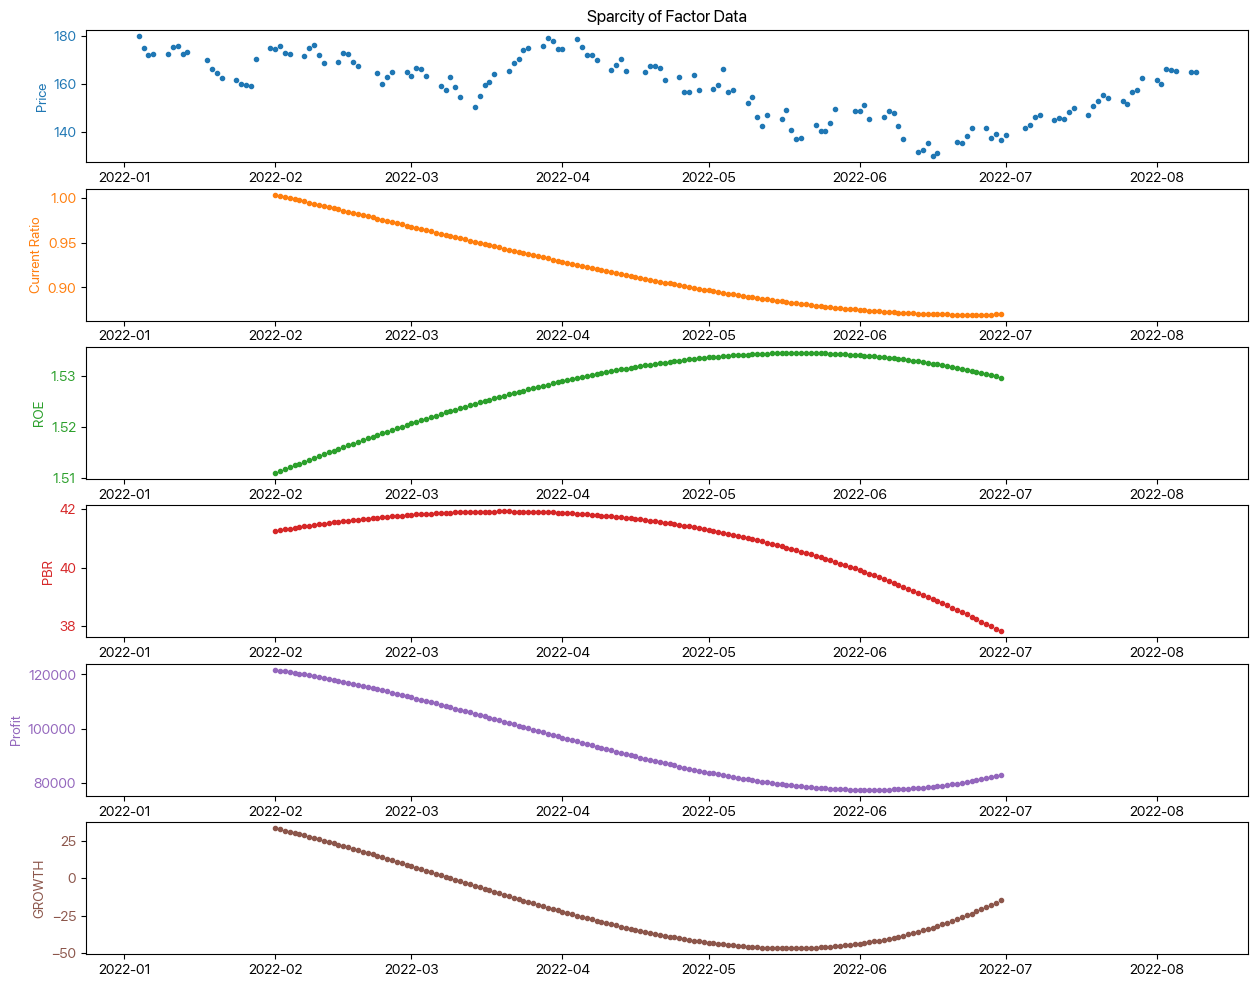

In [5]:
# Plot Price and stats in multiple axis
preview = 150

fig = plt.figure(figsize=(15, 12))
ax = plt.subplot(6, 1, 1)
ax.scatter(
    dow30.stocks[0].df["Date"].tail(preview),
    dow30.stocks[0].df["Close"].tail(preview),
    marker=".",
    label="Price",
    color="tab:blue",
)
ax.set_ylabel("Price", color="tab:blue")
ax.tick_params(axis="y", labelcolor="tab:blue")
ax.set_title("Sparcity of Factor Data")
colors = ["tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
colors.reverse()
for factor in dow30.stocks[0].dfStat.columns[1:]:
    color = colors.pop()
    plt.subplot(6, 1, (6 - len(colors)), sharex=ax)
    plt.plot(
        dow30.stocks[0].dfStat["Date"].tail(preview),
        dow30.stocks[0].dfStat[factor].tail(preview),
        ".",
        label=factor,
        color=color,
    )
    plt.ylabel(factor, color=color)
    plt.tick_params(axis="y", labelcolor=color)


In [6]:
dow30.calcIC("valuation", "2016-01-08")

0.5080254237598585

In [7]:
# Train Dataset
from StockHelper import createICDataFrame
IC_train, nextIC_train, icwithdate = createICDataFrame(dow30, TRAIN_PERIOD, CONFIG)


  0%|          | 0/292 [00:00<?, ?it/s]/Users/thkim/Documents/GitHub/MFSS-XGBoost/StockHelper.py:216: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  [np.mean(arr[i : i + kernel]) for i in range(0, len(arr) - kernel, stride)]
 26%|██▌       | 75/292 [01:02<03:08,  1.15it/s]/Users/thkim/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/thkim/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 292/292 [04:16<00:00,  1.14it/s]


In [8]:
print(IC_train.shape)

(286, 25)


In [9]:
# Test Dataset
from StockHelper import createICDataFrame
IC_test, nextIC_test, _ = createICDataFrame(dow30, TEST_PERIOD, CONFIG)
print(IC_test.shape, nextIC_test.shape)

  0%|          | 0/19 [00:00<?, ?it/s]/Users/thkim/Documents/GitHub/MFSS-XGBoost/StockHelper.py:216: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  [np.mean(arr[i : i + kernel]) for i in range(0, len(arr) - kernel, stride)]
100%|██████████| 19/19 [00:18<00:00,  1.03it/s]

(19, 25) (19, 6)


In [10]:
# IC Graph Generation
# icwithdate.plot.area(
    # figsize=(20, 5),
    # legend=True,
    # colormap="tab10",
    # title="IC Weights over training period",
# )
# plt.savefig(dpi=300, fname="icweights.png")


In [11]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

xgbModel = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.4,
        colsample_bylevel=0.6,
        colsample_bytree=0.4,
        reg_lambda=10,
        tree_method="hist",
    )
)

In [12]:
# Model Training
print(IC_train.shape, nextIC_train.shape)
xgbModel.fit(IC_train, nextIC_train)
print(xgbModel.score(IC_train, nextIC_train))


(286, 25) (286, 6)
0.5998886166999995


-0.16506585349790678


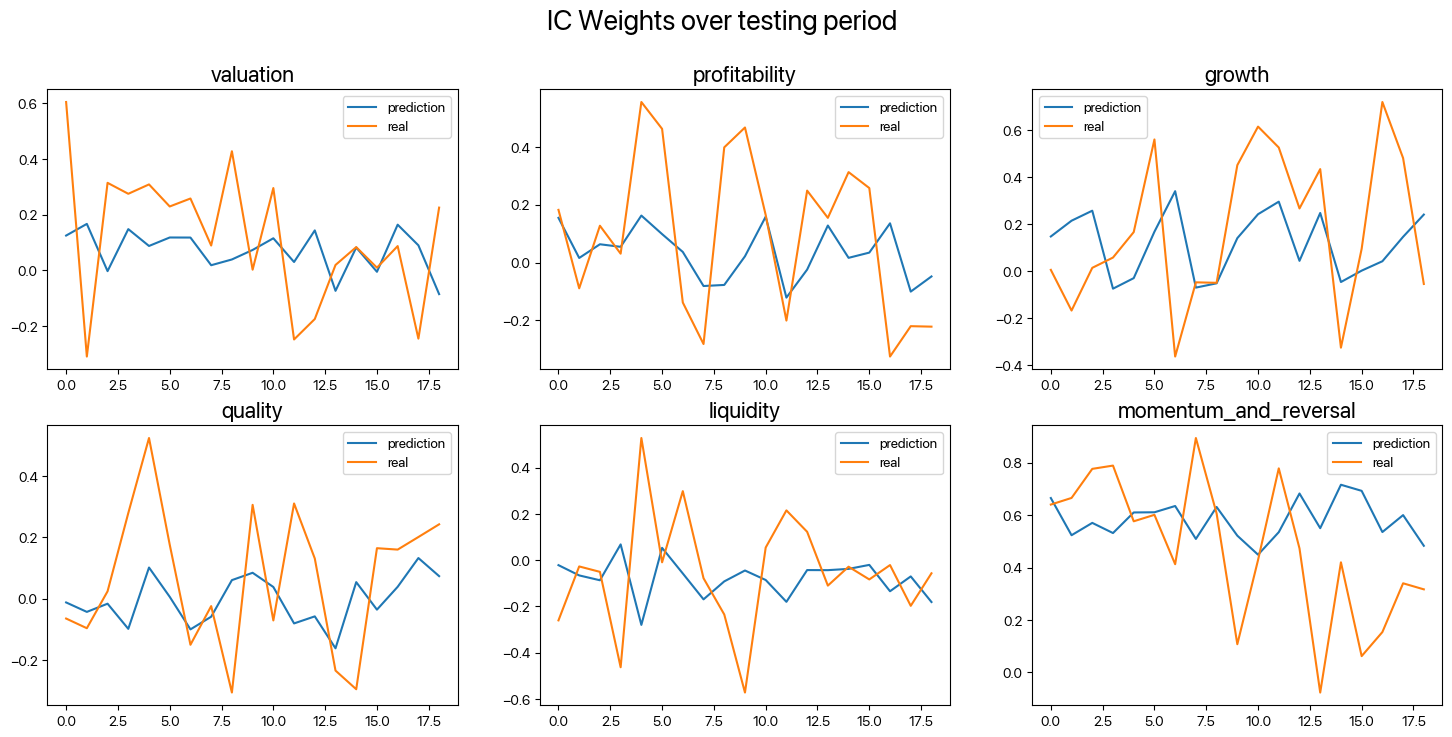

In [13]:
# Model Testing
print(xgbModel.score(IC_test, nextIC_test))
plt.figure(figsize=(18, 8))
plt.suptitle("IC Weights over testing period", fontsize=20)
IC_predict = pd.DataFrame(xgbModel.predict(IC_test), columns=FACTORS)
for i in range(len(FACTORS)):
    plt.subplot(2, 3, i + 1)
    plt.title(FACTORS[i], fontsize=16)
    plt.plot(IC_predict.iloc[:, i], label="prediction")
    plt.plot(nextIC_test.iloc[:, i], label="real")
    plt.legend()

plt.savefig(dpi=300, fname = "prediction.png")